In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5,5,0.25)
ys=f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

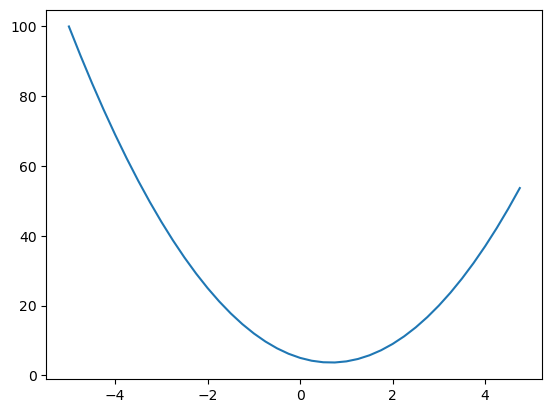

In [6]:
plt.plot(xs,ys)

In [103]:
class Value:
    def __init__(self,data,_children=(),_op="",label=""):
        self.data = data;
        self._prev = set(_children)
        self._op=_op
        self.label=label
        self.grad = 0
        self._backward = lambda : None
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other),"+")
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    def __radd__(self,other):
        return self + other

    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out =Value(self.data**other,(self,),f"**{other}")
        def _backward():
            self.grad = other*(self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self*(-1)
        
    def __sub__(self,other):
        return self + (-other)
    def __rmul__(self,other):
        return self * other
    def __truediv__(self,other):
        return self * other**-1
    def tanh(self):
        x= self.data
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),"tanh")
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),"exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for n in reversed(topo):
            n._backward()
        
    

a= Value(2.0,label='a')
b= Value(-3.0,label='b')
c = Value(10,label="c")
e= a*b;e.label="e"
d= e + c; d.label="d"
f = Value(-2.0,label="f")
L= f*d;L.label="L"

In [48]:
d._prev

{Value(data=-6.0), Value(data=10)}

In [49]:
d._op

'+'

In [18]:
!pip install graphviz

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ----------------- ---------------------- 20.5/47.1 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 784.8 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
from graphviz import Digraph

def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child,v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg",graph_attr={"rankdir":"LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{%s | data %.4f | grad %.4f}" %(n.label,n.data,n.grad),shape="record")
        if n._op:
            dot.node(name= uid +n._op, label=n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot
    
def draw_dot_RL(root):
    dot = Digraph(format="svg",graph_attr={"rankdir":"RL"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{data %.4f}" %(n.data,),shape="record")
        if n._op:
            dot.node(name= uid +n._op, label=n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

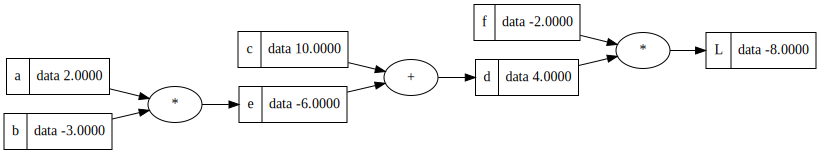

In [53]:
draw_dot(L)

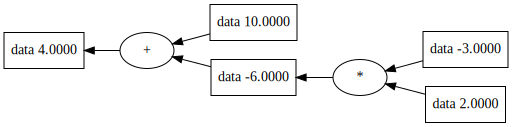

In [41]:
draw_dot_RL(d)

In [90]:
#defining inputs
x1= Value(2.0,label="x1")
x2=Value(0.0,label="x2")
#define bias
b=Value(6.88137358701955432,label="b")
#defining weights
w1=Value(-3.0,label="w1")
w2=Value(1.0,label="w2")
x1w1=x1*w1;x1w1.label="x1w1"
x2w2=x2*w2;x2w2.label="x2w2"
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label="x1w1x2w2"
n= x1w1x2w2+b;n.label="n"
o=n.tanh();o.label="o"


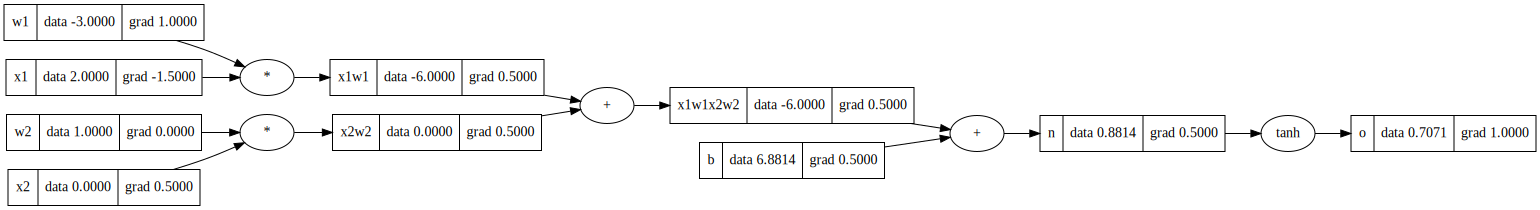

In [92]:
draw_dot(o)

In [91]:
o.backward()

In [89]:
a=Value(4)
b=Value(2)
a-b

Value(data=2)

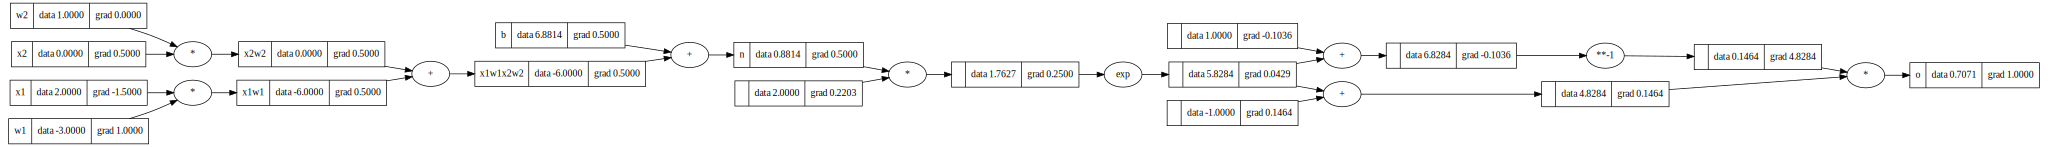

In [104]:
#defining inputs
x1= Value(2.0,label="x1")
x2=Value(0.0,label="x2")
#define bias
b=Value(6.88137358701955432,label="b")
#defining weights
w1=Value(-3.0,label="w1")
w2=Value(1.0,label="w2")
x1w1=x1*w1;x1w1.label="x1w1"
x2w2=x2*w2;x2w2.label="x2w2"
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label="x1w1x2w2"
n= x1w1x2w2+b;n.label="n"
#--------
e= (n*2).exp()
o=(e-1)/(e+1)
#------
o.label="o"
o.backward()
draw_dot(o)

In [105]:
import torch

In [115]:
x1=torch.Tensor([2.0]).double() ; x1.requires_grad =True
x2=torch.Tensor([0.0]).double() ; x2.requires_grad =True
#initialise weights'
w1=torch.Tensor([-3.0]).double(); w1.requires_grad=True
w2=torch.Tensor([1.0]).double() ; w2.requires_grad=True
b=torch.Tensor([6.88137358701955432]).double(); b.requires_grad=True
n=x1*w1 + x2*w2 + b
o= torch.tanh(n)
print(o.item())
print("----")
o.backward()

print("x2",x2.grad.item())
print("w2",w2.grad.item())
print("x1",x1.grad.item())
print("w1",w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [156]:
#Creating a neuron
import random
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    def parameters(self):
        params= self.w+[self.b]
        return params
class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        params = [p for neuron in self.neurons for p in neuron.parameters()]
        return params
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [158]:
x=[2.0,3.0,-1.0]
n=Neuron(2)
# n(x)
l=Layer(2,3)
# l(x)


Value(data=0.046056323657269076)

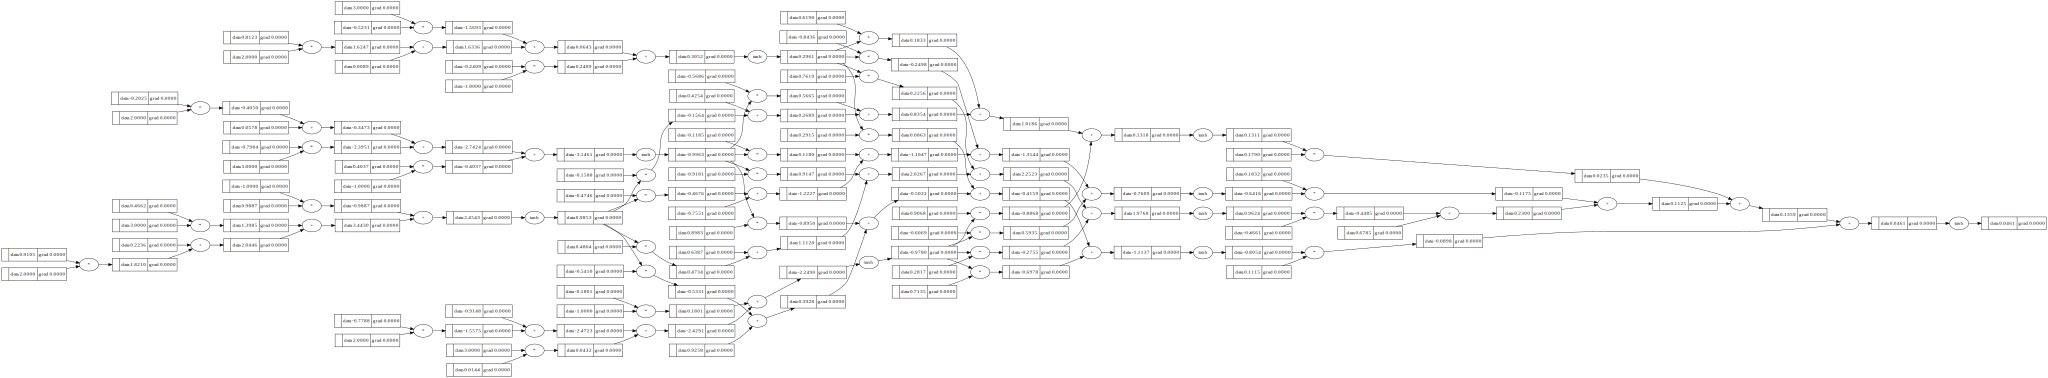

In [159]:
draw_dot(n(x))

In [227]:
n=MLP(3,[4,4,1])
n(x)
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys=[1.0,-1.0,-1.0,1.0]


ypred

[Value(data=0.7844694604511532),
 Value(data=-0.9156868789141392),
 Value(data=-0.9093991442524872),
 Value(data=0.7723156314862736)]

In [228]:
for k in range(5):
    #forward pass
    ypred=[n(x) for x in xs]
    loss = sum((ypre-ygt)**2 for ygt,ypre in zip(ys,ypred))
    #backward pass
    """
    from here onwards the optimzation process starts. The optimization problem comes about because of large data and the large epoch size required to
    converge at the minimal loss point for the large data there for concepts such as momentum and nestorov gradient decent came into place
    I have to try them out as well in the coming exercises.
    """
    #zerograd first
    # for p in n.parameters():
    #     p.grad=0
    loss.backward()
    #what is the most common bug when creating an MLP? not zero gradding before the next backward pass
    #update
    a=0.1#stepsize
    m=0.01
    for p in n.parameters():
        p.data+= -a*p.grad
        p.grad+=  m*p.grad
        
    #print current step and epoch
    print(loss.data,k)

4.6508954934553275 0
1.754280476707606 1
0.7397553076862675 2
0.03612591510867484 3
0.0021997524377634697 4


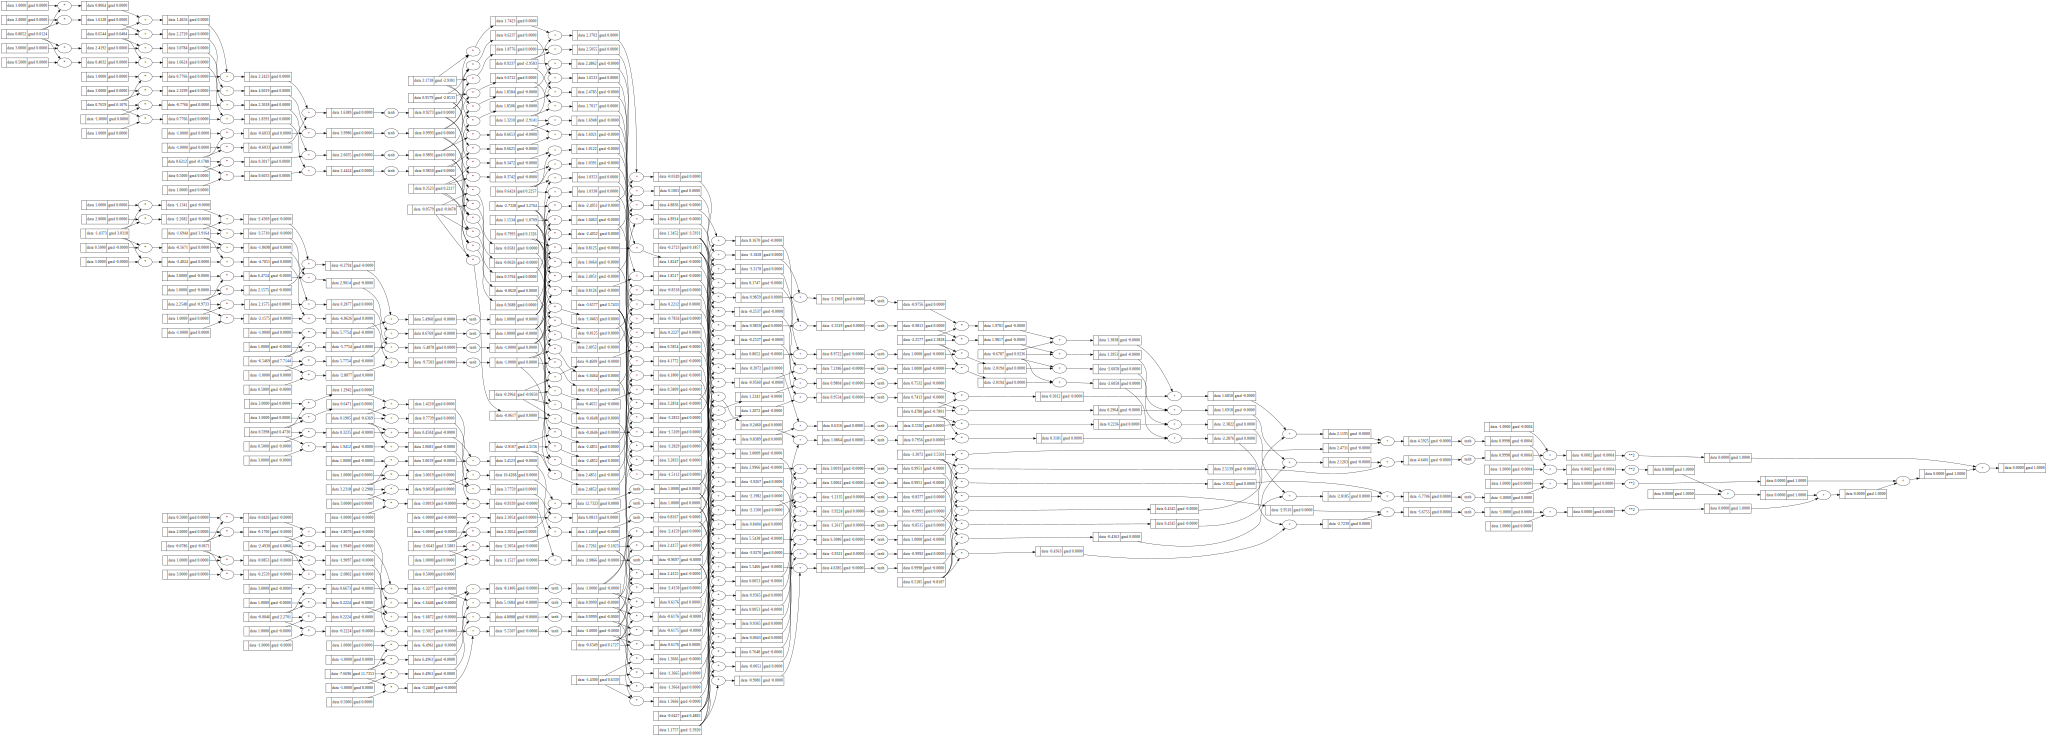

In [216]:
draw_dot(loss)

In [221]:
n.parameters()

[Value(data=-0.6990446184237032),
 Value(data=-0.2722538730218185),
 Value(data=-0.6209951598923746),
 Value(data=-0.9313890884657205),
 Value(data=-0.6472231010573144),
 Value(data=-0.36969461144244614),
 Value(data=0.5725137713386569),
 Value(data=0.9024992780486369),
 Value(data=-0.3214700707973841),
 Value(data=-0.1476738433784523),
 Value(data=1.0644052955671641),
 Value(data=0.5975201780456988),
 Value(data=-0.3580041992446132),
 Value(data=0.6921802310707497),
 Value(data=-0.6280688391620226),
 Value(data=-0.36112846803165627),
 Value(data=0.11293065599928387),
 Value(data=0.30593114206923194),
 Value(data=0.42065118949487346),
 Value(data=-0.5958221906104214),
 Value(data=0.671579691632965),
 Value(data=0.7440923261044581),
 Value(data=-0.748418941346491),
 Value(data=-0.711361415312174),
 Value(data=1.24679151332189),
 Value(data=0.509846128190068),
 Value(data=-0.8070171039677223),
 Value(data=-0.4394562394462706),
 Value(data=-0.17132241496877051),
 Value(data=0.771980059206

In [229]:
ypred

[Value(data=0.9768297914155505),
 Value(data=-0.9790401534606562),
 Value(data=-0.9734801317355941),
 Value(data=0.9771904561158649)]

In [165]:
n.layers[0].neurons[0].w[0].grad

0.15941491828889953

In [166]:
n.layers[0].neurons[0].w[0].data

0.9104836260030387

In [201]:
ypred

[Value(data=0.9994469815379131),
 Value(data=0.9993186024158718),
 Value(data=0.9993050966589602),
 Value(data=0.9960673157373521)]